### Exploring songs from Spotify and lyrics from Genius

In [1176]:
import pandas as pd


from spotipy.oauth2 import SpotifyClientCredentials
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
from collections import Counter
import time



#### How to get data from Spotify

To get data from the Spotify API, you will need to do next steps:

1) Create a Spotify Developer Account: Go to the Spotify Developer website (https://developer.spotify.com/) and create an account if you do not have one already.

2) Create a Spotify App: Once you have a Spotify Developer account, create a Spotify App. This will give you the necessary API credentials (Client ID and Client Secret) that you will need to authenticate and access the Spotify API.

3) Import spotipy library

In [1181]:
import spotipy


client_id = client_id
client_secret = client_secret

In [1177]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#### How to get data from Genius


To get lyrics from the Genius API, you need to follow these general steps:

1) Register and create an account on the Genius website: Go to https://genius.com and create an account if you don't have one already.

2) Register a new application on the Genius API: Once you have an account on the Genius website, go to https://genius.com/api-clients/new and register a new application. This will provide you with an API key, which you will use to authenticate your requests to the Genius API.

3) Install a library for interacting with the Genius API: You can use a Python library, such as 'lyricsgenius', to interact with the Genius API. You can install the 'lyricsgenius' library using pip, by running the following command in your Python environment:

In [1178]:
import lyricsgenius

In [934]:
YOUR_ACCESS_TOKEN_HERE = YOUR_ACCESS_TOKEN_HERE
genius = lyricsgenius.Genius(YOUR_ACCESS_TOKEN_HERE, timeout=20)


### Retrieve Song Data from Spotify:


In [1183]:
#  Search for a song by its name and retrieve its data
song_name = 'Perfect'  # Replace with the name of the song you want to retrieve
results = sp.search(q=song_name, type='track', limit=1)
if results['tracks']['items']:
    track = results['tracks']['items'][0]
    print('Song Name:', track['name'])
    print('Artist(s):', ', '.join([artist['name'] for artist in track['artists']]))
    print('Album:', track['album']['name'])
    print('Release Date:', track['album']['release_date'])
else:
    print('No results found for the given song name.')

Song Name: Perfect
Artist(s): Ed Sheeran
Album: ÷ (Deluxe)
Release Date: 2017-03-03


### Retrieve Artist Data:


In [1184]:
artist_name = 'Ed Sheeran'  # Replace with the name of the artist you want to retrieve
results = sp.search(q=artist_name, type='artist', limit=1)
if results['artists']['items']:
    artist = results['artists']['items'][0]
    print('Artist Name:', artist['name'])
    print('Genres:', ', '.join(artist['genres']))
    print('Popularity:', artist['popularity'])
    print('Followers:', artist['followers']['total'])
else:
    print('No results found for the given artist name.')

Artist Name: Ed Sheeran
Genres: pop, uk pop
Popularity: 92
Followers: 111027294


In [941]:
# Search for Ed Sheeran's artist ID 
results = sp.search(q='Ed Sheeran', type='artist')

Ed Sheeran in not a unique name, so we need to get all Eds and find the most popular one (I guess it is safe to say so)

In [945]:
data = []

for artist in results['artists']['items']:
    number_of_followers = artist['followers']['total']
    name = artist['name']
    artist_id = artist['id']
    popularity = artist['popularity']
    genres = artist['genres']
    

    artist_dict = {
    'number_of_followers': number_of_followers,
    'name': name,
    'artist_id': artist_id,
    'popularity': popularity,
    'genres': genres
    }
    
    data.append(artist_dict)
    
artist_df = pd.DataFrame(data).sort_values(by='number_of_followers', ascending=False)
    

In [947]:
edsheeran_id = artist_df['artist_id'][0]
artist_id = edsheeran_id


In [780]:
albums = sp.artist_albums(artist_id)

### Retrieve all albums by artist ID

In [949]:
offset = 0
limit = 50
total = None
all_albums = []

# Loop until all albums have been retrieved
while total is None or offset < total:
    # Make request for albums
    results = sp.artist_albums(artist_id, limit=limit, offset=offset, album_type = 'album')
    # Add retrieved albums to list
    all_albums.extend(results['items'])
    
    # Update total number of albums
    if total is None:
        total = results['total']
    
    # Update offset for next set of results
    offset += len(results['items'])

# Create DataFrame from retrieved albums
all_albums = pd.DataFrame(all_albums)

There are more albums that were written by Sheeran (domain knowledge is a key to data prep), so we need to drop them as well as life ones.

In [950]:
all_albums['num_countries'] = all_albums['available_markets'].apply(lambda x: len(x))
filtered_studio_albums = all_albums[['name', 'id', 'release_date', 'total_tracks' ,'num_countries']][    (all_albums['name'].str.contains('Deluxe') 
    |  ~(all_albums['name'].str.contains('Edition') | all_albums['name'].str.contains('Remixes')))
]
filtered_studio_albums = filtered_studio_albums[filtered_studio_albums['num_countries'] > 1].drop_duplicates(subset=['name'])


### Retrieve songs features by track ID

In [953]:
def extract_features(track):
    features = sp.audio_features(track['id'])
    if len(features) > 0:
        return features[0]
    else:
        return None

# Set up empty list to store track data
track_data = []


# Loop through albums and retrieve track data
for index, row in filtered_studio_albums.iterrows():
    album_id = row['id']
    album_name = row['name']

    tracks = sp.album_tracks(album_id)['items']
    for track in tracks:
        track_name = track['name'].split("(")[0].strip().split("-")[0].strip()
        features = extract_features(track)
        track_data.append({'album_name': album_name, 'track_name': track_name, 'track_features': features})

# Convert list of dictionaries to dataframe
tracks = pd.DataFrame(track_data)



In [954]:
keys = set().union(*(d.keys() for d in tracks['track_features']))
for key in keys:
    tracks[key] = tracks['track_features'].apply(lambda x: x[key] if key in x else None)

# Drop the original feature column
tracks.drop('track_features', axis=1, inplace=True)
merged_df = pd.merge(filtered_studio_albums[['name', 'release_date']], tracks, left_on='name', right_on='album_name')
merged_df = merged_df.drop_duplicates(subset='track_name', keep='first', inplace=False)


In [932]:
def get_lyrics(track_name):
    try:
        song = genius.search_song(track_name, artist=artist_name)

        return song.lyrics
    except:
        return "Lyrics not found"

# Apply the get_lyrics() function to the track_name column and create a new column called lyrics
merged_df['lyrics'] = merged_df['track_name'].apply(get_lyrics)



Searching for "Tides" by Ed Sheeran...
Done.
Searching for "Shivers" by Ed Sheeran...
Done.
Searching for "First Times" by Ed Sheeran...
Done.
Searching for "Bad Habits" by Ed Sheeran...
Done.
Searching for "Overpass Graffiti" by Ed Sheeran...
Done.
Searching for "The Joker And The Queen" by Ed Sheeran...
Done.
Searching for "Leave Your Life" by Ed Sheeran...
Done.
Searching for "Collide" by Ed Sheeran...
Done.
Searching for "2step" by Ed Sheeran...
Done.
Searching for "Stop The Rain" by Ed Sheeran...
Done.
Searching for "Love In Slow Motion" by Ed Sheeran...
Done.
Searching for "Visiting Hours" by Ed Sheeran...
Done.
Searching for "Sandman" by Ed Sheeran...
Done.
Searching for "Be Right Now" by Ed Sheeran...
Done.
Searching for "Beautiful People" by Ed Sheeran...
Done.
Searching for "South of the Border" by Ed Sheeran...
Done.
Searching for "Cross Me" by Ed Sheeran...
Done.
Searching for "Take Me Back to London" by Ed Sheeran...
Done.
Searching for "Best Part of Me" by Ed Sheeran...
D

In [856]:
merged_df.to_csv("merged_df.csv", index=False)
ed_sheeran_pd = pd.read_csv("merged_df.csv")

### Find out most favourite Ed Sheeran words

In [1237]:
words_to_drop = ['chorus', 'prechorus', 'verse', 'bridge', 'ed', 'sheeran','embed']

In [1238]:
# Make lyrics more readable
def transform_lyrics(lyrics):
    result = re.sub(r'[^\w\s]', '', lyrics)
    result = re.sub(r'\d', ' ', result)
    lyrics = result.strip().replace("\n", " ").replace("\r", " ").replace("\'", " ").replace('[', '').replace(']', '').replace(',', '').lower()

    words = lyrics.split()
    filtered_words = [word for word in words if word not in words_to_drop]
    lyrics = " ".join(filtered_words)
    if "[Verse 1]" in lyrics:
        lyrics = lyrics.split("[Verse 1]")
        result = "[Verse 1]" + lyrics[1]
    else:
        result = lyrics
    return result

In [1239]:
ed_sheeran_pd.lyrics = ed_sheeran_pd.lyrics.apply(transform_lyrics)

In [1240]:
# Drop repeatable words
def unique_words_in_lyrics(lyrics):
    words_list = lyrics.split()
    # Convert list to set to keep only unique words
    unique_words_set = set(words_list)
    # Convert set back to list
    unique_words_list = list(unique_words_set)
    # Print the unique words
    return ' '.join(unique_words_list)

In [1241]:
ed_sheeran_pd['unique_words_in_lyrics'] = ed_sheeran_pd['lyrics'].apply(unique_words_in_lyrics)

In [1242]:
ed_sheeran_pd['number_of_words'] = ed_sheeran_pd.unique_words_in_lyrics.apply(len)
print(f"{artist_name} used {sum(ed_sheeran_pd['number_of_words'])} words in his songs")

Ed Sheeran used 79809 words in his songs


In [1243]:
df = ed_sheeran_pd

In [1244]:
stop_words = pd.read_csv('stop_words.csv')

In [1245]:
stop_words = [
    "a", "an", "the",'sheeran','could', "and","also", "is", "of", "in", "to", "that", "it", "with",
    "as", "for", "on", "was", "at", "by", "this", "or", "but", "not", "be",
    "from", "are", "you", "we", "can", "if", "when", "where", "how", "which",
    "has", "have", "had", "were", "been", "am", "their", "there", "being",
    "who", "whom", "while", "about", "so", "up", "out", "into", "over",
    "under", "then", "them", "your", "my", "his", "her", "its", "our", "their",
    "some", "such", "no", "any", "only", "very", "just", "but", "with",
    "that", "than", "like", "because", "since", "until", "unless", "although",
    "while", "whereas", "whether", "if", "unless", "until", "where", "wherever",
    "when", "whenever", "why", "what", "which", "who", "whom", "whose", "how",
    "however", "whoever", "whichever", "whatever", "whomever", "whosever",
    "therefore", "thus", "hence", "accordingly", "consequently", "otherwise",
    "meanwhile", "furthermore", "moreover", "nevertheless", "nonetheless",
    "however", "otherwise", "else", "otherwise", "yet", "still", "also",
    "besides", "too", "either", "neither", "nor", "both", "each", "every",
    "all", "another", "other", "such", "quite", "few", "several", "many",
    "some", "most", "little", "much", "enough", "more", "less", "least",
    "only", "just", "even", "not", "neither", "nor", "but", "besides",
    "on", "at", "for", "ago", "since", "until", "before", "after", "by",
    "with", "without", "about", "between", "among", "through", "during",
    "in", "inside", "on", "onto", "off", "out", "up", "down", "up",
    "over", "under", "above", "below", "across", "throughout", "round",
    "beneath", "beside", "behind", "among", "beyond", "toward", "towards",
    "along", "besides", "past", "following", "like", "unlike", "according",
    "due", "except",'cause', "barring", "sparing", "regarding", "concerning",
    "considering", "touching", "amid", "amidst", "despite", "in", "into",
    "inside", "per", "pro", "within", "withal", "bar", "failing", "re", "wanna", "i",
    "mmy", "mymy", 'the', 'yeah','s','me','ll','t','chorus', 'prechorus', 'verse', 'm','might', 'oh',
'got','get', 'us','will','1','2','3','4','5','6','7','8','9','10', 'ye','don','ve', 'he', 'mymyy', 'do', 'pre-chorus', 'ed', 'sheeran', 'bridge' ]

In [1246]:
stop_words = pd.DataFrame(stop_words, columns=['eng'])
stop_words.to_csv('stop_words.csv')

In [1247]:

def most_common_words(lyrics, N):
    # Concatenate all unique_words_in_lyrics values into a single string
    all_words = ' '.join(lyrics)

    # Split the string into individual words
    words_list = all_words.split()

    # Remove the stop words from the words list
    words_list = [word for word in words_list if word not in list(stop_words['eng'])]

    # Count the frequency of each word
    word_counter = collections.Counter(words_list)

    # Convert the word counter to a DataFrame
    word_df = pd.DataFrame(list(word_counter.items()), columns=['Word', 'Frequency'])

    # Sort the DataFrame by frequency in descending order
    word_df = word_df.sort_values('Frequency', ascending=False)

    # Select the top N words
    top_N_words = word_df.head(N)
    return top_N_words


In [1248]:
common_words_all_songs = most_common_words(df['unique_words_in_lyrics'], 15)['Word']

In [1249]:
df = ed_sheeran_pd

# Iterate over each album in the DataFrame
album_common_words = {}
for album in df['album_name'].unique():
    # Filter the DataFrame to get lyrics for the current album
    album_lyrics = df[df['album_name'] == album]['unique_words_in_lyrics']
    album_common_words[album] = most_common_words(album_lyrics,15)

album1_common_words = album_common_words['=']['Word']
album2_common_words = album_common_words['÷ (Deluxe)']['Word']
album3_common_words = album_common_words['+']['Word']
album4_common_words = album_common_words['x (Deluxe Edition)']['Word']

In [1250]:
def word_clod_plt(words):
    text = ' '.join(words)
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Ed Sheeran diffinetly "know" all about "love"

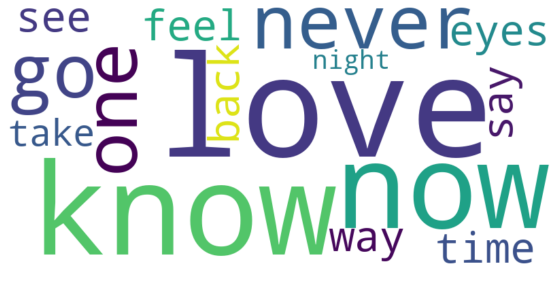

In [1251]:
word_clod_plt(common_words_all_songs)

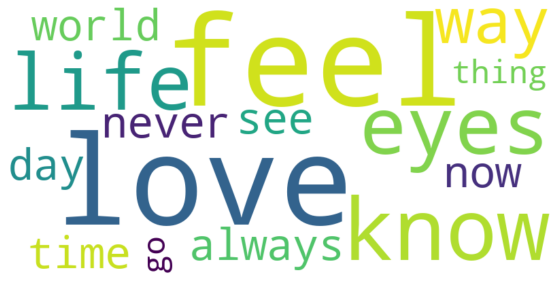

In [1079]:
word_clod_plt(album1_common_words)

Feature analysis

In [1081]:
df.columns

Index(['name', 'release_date', 'album_name', 'track_name', 'time_signature',
       'tempo', 'track_href', 'mode', 'key', 'liveness', 'uri', 'type',
       'danceability', 'valence', 'analysis_url', 'id', 'speechiness',
       'energy', 'loudness', 'duration_ms', 'acousticness', 'instrumentalness',
       'lyrics', 'unique_words_in_lyrics', 'unique_words'],
      dtype='object')

In [1088]:
df.album_name.unique()

array(['=', 'No.6 Collaborations Project', '÷ (Deluxe)', '5',
       'x (Deluxe Edition)', '+'], dtype=object)

In [1089]:
math_albums = ['=',  '÷ (Deluxe)', 'x (Deluxe Edition)', '+']

In [1091]:
math_only_df = df[df['album_name'].isin(math_albums)]

In [1096]:

# Sort DataFrame by 'release_date' in ascending order
math_only_df = math_only_df.sort_values('release_date', ascending=True)

# Create a new column 'song_number' with the number of each song in the DataFrame
math_only_df['song_number'] = range(1, len(math_only_df) + 1)

In [1130]:
def plot_feature(feature):
    avg_feature_by_album = math_only_df.groupby('album_name')[feature].mean().reset_index()
    max_feature = math_only_df[math_only_df[feature] == math_only_df[feature].max()]

    # Create line chart
    fig = px.line(math_only_df, x='track_name', y=feature, color='album_name')

    for album in avg_feature_by_album['album_name']:
        avg_feature = avg_feature_by_album[avg_feature_by_album['album_name'] == album][feature].iloc[0]
        album_df = math_only_df[math_only_df['album_name'] == album]
        x0 = album_df['song_number'].min()
        x1 = album_df['song_number'].max()
        fig.add_shape(type='line',
                      x0=x0, x1=x1,
                      y0=avg_feature, y1=avg_feature,
                      xref='x', yref='y',
                      line=dict(color=px.colors.qualitative.Plotly[avg_feature_by_album[avg_feature_by_album['album_name'] == album].index[0]],
                                dash='dash'),
                      opacity=0.5,
                      name=f'Average Danceability for {album}')
    fig.add_trace(go.Scatter(x=max_feature['track_name'], y=max_feature[feature],
                             mode='markers',
                             marker=dict(size=10, color='red', symbol='star-diamond'),
                             showlegend=False,
                             name=f'Song with Highest {feature}'))
    fig.update_traces(mode='markers')
    fig.update_layout(height=600, width=1200)  # Update size of the plot

    fig.show()

In [1133]:
df.columns

Index(['name', 'release_date', 'album_name', 'track_name', 'time_signature',
       'tempo', 'track_href', 'mode', 'key', 'liveness', 'uri', 'type',
       'danceability', 'valence', 'analysis_url', 'id', 'speechiness',
       'energy', 'loudness', 'duration_ms', 'acousticness', 'instrumentalness',
       'lyrics', 'unique_words_in_lyrics', 'unique_words'],
      dtype='object')

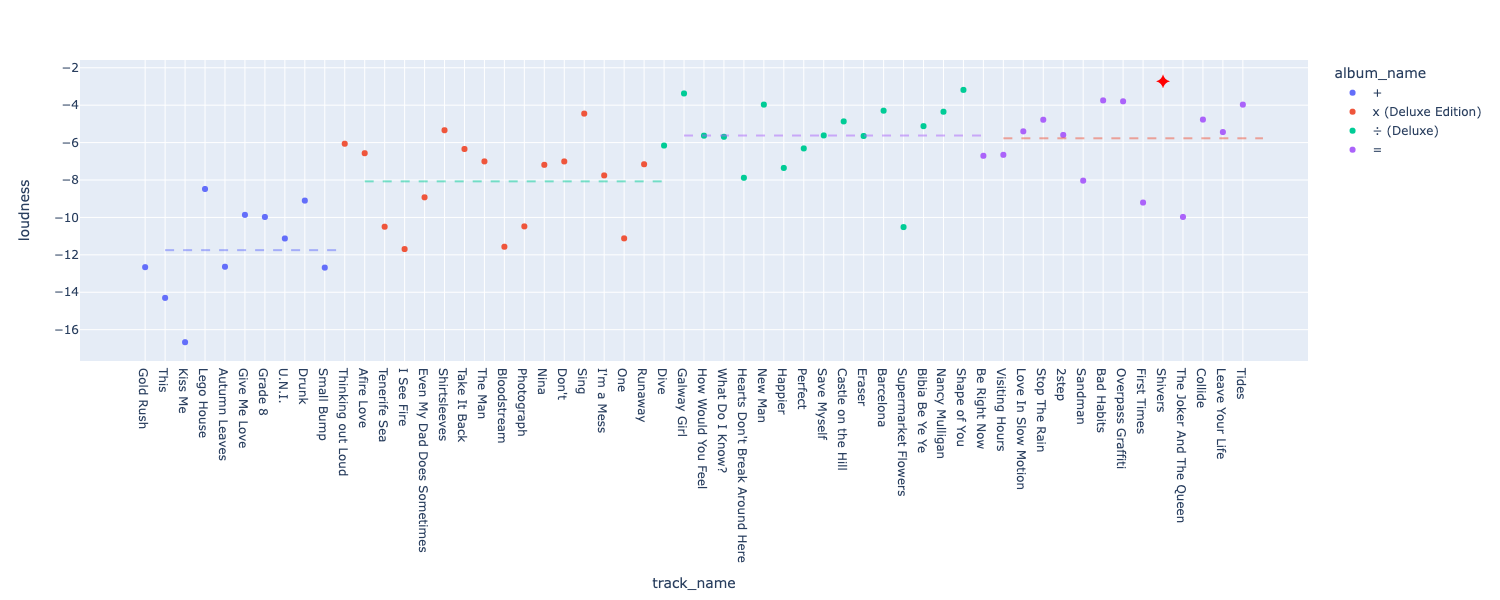

In [1139]:
plot_feature('loudness')

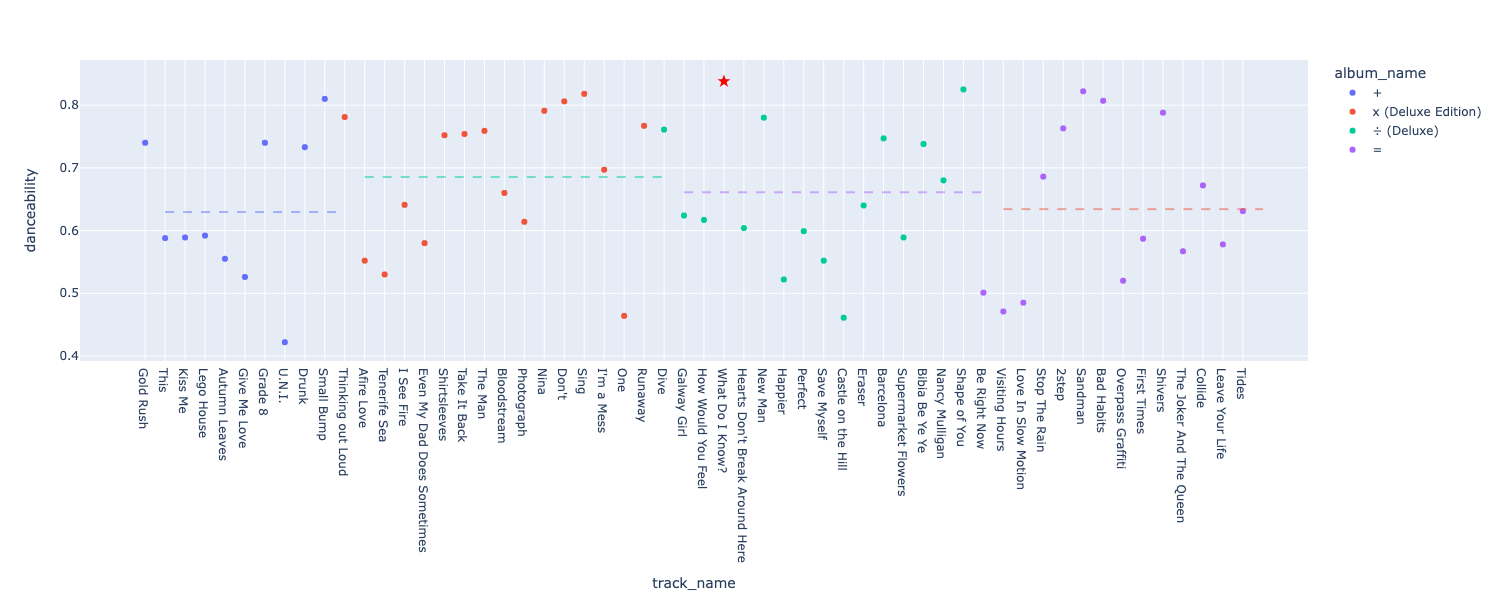

In [1113]:
import plotly.express as px
import pandas as pd


avg_danceability_by_album = math_only_df.groupby('album_name')['danceability'].mean().reset_index()
max_danceability = math_only_df[math_only_df['danceability'] == math_only_df['danceability'].max()]

# Create line chart
fig = px.line(math_only_df, x='track_name', y='danceability', color='album_name')

for album in avg_danceability_by_album['album_name']:
    avg_danceability = avg_danceability_by_album[avg_danceability_by_album['album_name'] == album]['danceability'].iloc[0]
    album_df = math_only_df[math_only_df['album_name'] == album]
    x0 = album_df['song_number'].min()
    x1 = album_df['song_number'].max()
    fig.add_shape(type='line',
                  x0=x0, x1=x1,
                  y0=avg_danceability, y1=avg_danceability,
                  xref='x', yref='y',
                  line=dict(color=px.colors.qualitative.Plotly[avg_danceability_by_album[avg_danceability_by_album['album_name'] == album].index[0]],
                            dash='dash'),
                  opacity=0.5,
                  name=f'Average Danceability for {album}')
fig.add_trace(go.Scatter(x=max_danceability['track_name'], y=max_danceability['danceability'],
                         mode='markers',
                         marker=dict(size=10, color='red', symbol='star'),
                         showlegend=False,
                         name='Song with Highest Danceability'))
fig.update_traces(mode='markers')
fig.update_layout(height=600, width=1200)  # Update size of the plot

fig.show()


In [1105]:
df.pivot_table(values = ['tempo', 'valence', 
                         'liveness','danceability','energy', 'acousticness', 'instrumentalness','speechiness', 'loudness'] , index = 'album_name', aggfunc = 'mean')

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
album_name,,,,,,,,,
+,0.594260,0.629500,0.408990,1.027499e-03,0.149460,-11.749700,0.065690,107.084300,0.494300
5,0.551577,0.636462,0.498231,5.739054e-04,0.210373,-8.321346,0.118896,111.650538,0.451500
=,0.356605,0.634143,0.609857,4.641429e-05,0.126450,-5.770500,0.064086,119.281714,0.538571
No.6 Collaborations Project,0.227096,0.713400,0.659600,7.208180e-04,0.217993,-6.344933,0.134880,105.556333,0.624667
x (Deluxe Edition),0.457831,0.685375,0.488062,7.883500e-05,0.193663,-8.072500,0.066031,102.867938,0.565063
÷ (Deluxe),0.382287,0.661062,0.578500,7.125000e-07,0.140381,-5.622937,0.067769,105.539062,0.585438


In [1167]:
import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import HTML
import pandas as pd

# Create a Text widget for manual word input
word_text = widgets.Text(
    description='Enter a word:',
    style={'description_width': 'initial'}
)

# Create a Button widget for triggering the search
search_button = widgets.Button(description='Search')

# Create an Output widget for displaying the search results
search_output = widgets.Output()

# Define a function to search for songs containing the entered word
def search_songs(button):
    search_word = word_text.value.lower() # Get the entered word and convert to lowercase
    # Search for songs containing the search word in the 'lyrics' column
    songs_list = df[df['lyrics'].str.lower().str.contains(search_word, na=False)]['track_name'].tolist()
    with search_output:
        # Clear the previous search results
        search_output.clear_output()
        # Display the search results
        if songs_list:
            print('Songs containing the word "{}":'.format(search_word))
            for song in songs_list:
                print(song)
        else:
            print('No songs found containing the word "{}".'.format(search_word))

# Add a click event handler to the search button
search_button.on_click(search_songs)

# Display the widgets in the Jupyter Notebook
display(word_text)
display(search_button)
display(search_output)


Text(value='', description='Enter a word:', style=DescriptionStyle(description_width='initial'))

Button(description='Search', style=ButtonStyle())

Output()

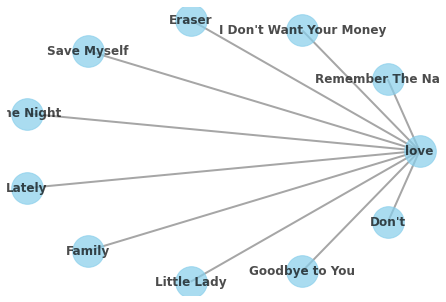

In [1175]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the word input
center_word = 'love'
search_word = word_text.value.lower() # Get the entered word and convert to lowercase

# Search for songs containing the search word in the 'lyrics' column
song_names = df[df['lyrics'].str.lower().str.contains(search_word, na=False)]['track_name'].tolist()

# Create an empty graph
G = nx.Graph()

# Add the center word as a node to the graph
G.add_node(center_word)

# Add song names as nodes to the graph
G.add_nodes_from(song_names)

# Add edges (connections) between the center word and song names
for song in song_names:
    G.add_edge(center_word, song)

# Draw the graph using circular layout
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', alpha=0.7, edge_color='gray', width=2)
plt.show()


In [1170]:
df_sorted = df.sort_values(by='tempo', ascending=False)
top_10_songs = df_sorted.head(10)

print(top_10_songs[['track_name', 'tempo']])

               track_name    tempo
4       Overpass Graffiti  175.908
27  Way To Break My Heart  170.125
55                Firefly  159.917
92             Lego House  159.701
60                    She  157.783
91                   This  152.139
20             Antisocial  151.957
11         Visiting Hours  149.609
1                 Shivers  141.020
65                 Family  140.396


In [659]:
for feature in ['tempo', 'valence','liveness','danceability','energy',
 'acousticness', 'instrumentalness','speechiness', 'loudness', 'mode']:
    df_sorted = df.sort_values(by=feature, ascending=False)
    top_10_songs = df_sorted.head(10)
    print(feature)
    print(' ')

    print(top_10_songs[['track_name', feature]])
    print(' ')


tempo
 
               track_name    tempo
4       Overpass Graffiti  175.908
27  Way To Break My Heart  170.125
55                Firefly  159.917
92             Lego House  159.701
60                    She  157.783
91                   This  152.139
20             Antisocial  151.957
11         Visiting Hours  149.609
1                 Shivers  141.020
65                 Family  140.396
 
valence
 
         track_name  valence
73             Sing    0.939
32     Shape of You    0.931
29           Eraser    0.914
20       Antisocial    0.910
79          Runaway    0.908
83     Take It Back    0.904
38  What Do I Know?    0.895
96        Gold Rush    0.889
42   Bibia Be Ye Ye    0.882
51         Homeless    0.875
 
liveness
 
           track_name  liveness
62         Wake Me Up     0.897
61         The A Team     0.833
21  Remember The Name     0.798
74              Don't     0.635
87              Drunk     0.521
63             Lately     0.391
28               BLOW     0.380
23   Pu

In [673]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [675]:
df.columns

Index(['name', 'release_date', 'album_name', 'track_name', 'time_signature',
       'tempo', 'track_href', 'mode', 'key', 'liveness', 'uri', 'type',
       'danceability', 'valence', 'analysis_url', 'id', 'speechiness',
       'energy', 'loudness', 'duration_ms', 'acousticness', 'instrumentalness',
       'lyrics', 'unique_words_in_lyrics'],
      dtype='object')

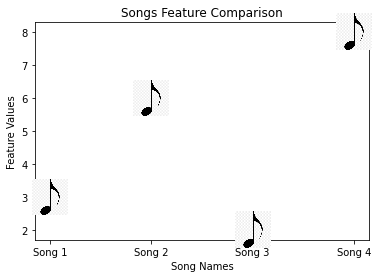

In [674]:
song_names = ['Song 1', 'Song 2', 'Song 3', 'Song 4']
feature_values = [3, 6, 2, 8]

# Load the image file for the marker symbol
image_path = 'music_note.png'  # Replace with the actual file path of the image

img = plt.imread(image_path)

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(song_names, feature_values, s=200, c='black', linewidths=2)

# Add custom markers using AnnotationBbox
for i in range(len(song_names)):
    img_marker = OffsetImage(img, zoom=0.1)
    ab = AnnotationBbox(img_marker, (song_names[i], feature_values[i]),
                         xycoords='data', frameon=False)
    ax.add_artist(ab)

# Add labels and title
ax.set_xlabel('Song Names')
ax.set_ylabel('Feature Values')
ax.set_title('Songs Feature Comparison')

# Show the plot
plt.show()







In [683]:
df = ed_sheeran_pd

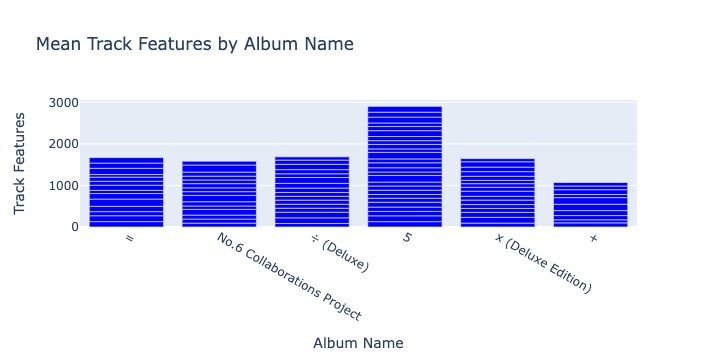

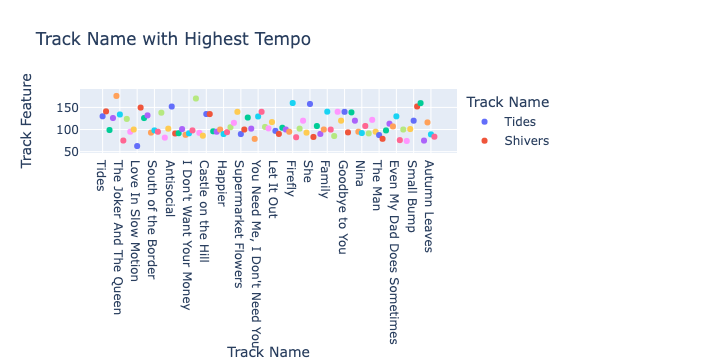

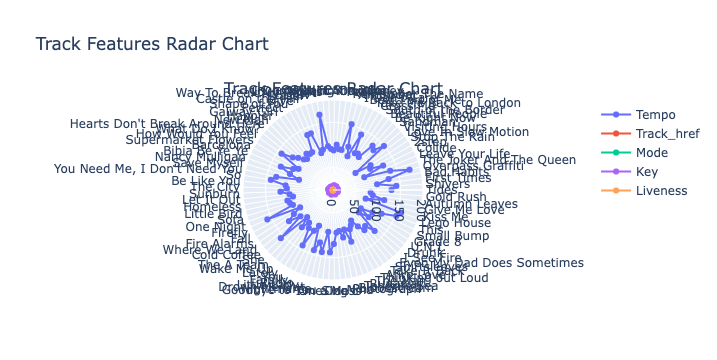

AttributeError: module 'plotly.subplots' has no attribute 'make'

In [685]:
import plotly.subplots as sp
import plotly.graph_objects as go
import pandas as pd


fig1 = go.Figure()

fig1.add_trace(go.Bar(x=df['album_name'], y=df['tempo'], marker_color='blue', 
                     name='Tempo', legendgroup='tempo'))


fig1.update_layout(barmode='group', title='Mean Track Features by Album Name',
                  xaxis_title='Album Name', yaxis_title='Track Features')

fig1.show()

# Chart 2 - Scatter Plot showing track_name with highest value in track features
chart2_feature = 'tempo'  # Choose the track feature to show on the chart
fig2 = px.scatter(df, x='track_name', y=chart2_feature, color='track_name',
                 labels={'track_name': 'Track Name', chart2_feature: 'Track Feature'},
                 title='Track Name with Highest {}'.format(chart2_feature.capitalize()))
fig2.show()

# Chart 3 - Radar Chart showing track features for each track_name
chart3_features = ['tempo', 'track_href', 'mode', 'key', 'liveness']  # Choose the track features to show on the chart
fig3 = sp.make_subplots(rows=1, cols=1, subplot_titles=('Track Features Radar Chart',))

for feature in chart3_features:
    fig3.add_trace(go.Scatterpolar(r=df[feature], theta=df['track_name'], mode='lines+markers', 
                                   name=feature.capitalize()))

fig3.update_layout(polar=dict(radialaxis=dict(range=[0, 200])), 
                   title='Track Features Radar Chart')
fig3.show()

# Create the Plotly Dashboard
dashboard = sp.make


In [690]:
def search_lyrics(dataframe, word):
    """Searches for the given word in the 'lyrics' column of a dataframe."""
    # Convert the 'lyrics' column to lowercase for case-insensitive search
    dataframe['lyrics'] = dataframe['lyrics'].str.lower()
    # Filter rows that contain the word in the 'lyrics' column
    result = dataframe[dataframe['lyrics'].str.contains(word.lower())]
    return result['track_name']

In [692]:
result = search_lyrics(df, 'baby')
print(result)


1                            Shivers
4                  Overpass Graffiti
7                            Collide
10               Love In Slow Motion
15               South of the Border
16                          Cross Me
18                   Best Part of Me
19                      I Don't Care
22                             Feels
23                  Put It All on Me
25           I Don't Want Your Money
28                              BLOW
31                              Dive
32                      Shape of You
33                           Perfect
34                       Galway Girl
35                           Happier
36                           New Man
37    Hearts Don't Break Around Here
41                         Barcelona
64                               You
72                        I'm a Mess
74                             Don't
76                        Photograph
80                           The Man
81                 Thinking out Loud
83                      Take It Back
N

In [701]:
len(df['track_name'].unique())

97

In [703]:
len(df['album_name'].unique())

6

In [705]:
df[df['lyrics'] == 'lyrics not found']

,name,release_date,album_name,track_name,time_signature,tempo,track_href,mode,key,liveness,...,analysis_url,id,speechiness,energy,loudness,duration_ms,acousticness,instrumentalness,lyrics,unique_words_in_lyrics
0,=,2021-10-29,=,Tides,3,129.942,https://api.spotify.com/v1/tracks/2JiHR4gCDjXw...,1,11,0.122,...,https://api.spotify.com/v1/audio-analysis/2JiH...,2JiHR4gCDjXwYVRDmwdk95,0.0433,0.825,-3.971,195760,0.0167,0.0,lyrics not found,found not Lyrics


In [748]:
df['unique_words_in_lyrics_len'] = df['unique_words_in_lyrics'].apply(len)

In [749]:
df['unique_words_in_lyrics_len'].sum()

95687